This project tries to perform text mining on reviews of a hotel (Hilton Garden Inn Kuala Lumpur - North) in Kuala Lumpur. The reviews were extracted from Booking.com.

In [190]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud

from textblob import TextBlob
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

In [117]:
g_url = 'https://www.booking.com/reviews/my/hotel/hilton-garden-inn-kuala-lumpur-jalan-tuanku-abdul-rahman.html?page='

pages = [page for page in range(1,18)]
url_list = [g_url + str(i) for i in pages]

info = []
pos_reviews = []
neg_reviews = []

for url in url_list:
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.text, 'html.parser')
    review_box = soup.find('ul', {'class': 'review_list'})
    
    ratings = [i.text.strip() for i in review_box.find_all('span', {'class': 'review-score-badge'})]
    
    reviewer = [i.text.strip() for i in review_box.find_all('span', {'itemprop': 'name'})]
    reviewer_name = reviewer[0::3]
    reviewer_country = reviewer[1::3]
    general_review = reviewer[2::3]
    
    review_date = [i.text.strip().strip('Reviewed: ') for i in review_box.find_all('p', {'class': 'review_item_date'})]
    
    review_tags = [i.text.strip().replace('•', ',').replace('\n\n\n', '').lstrip(', ') for i in review_box.find_all('ul', {'class': 'review_item_info_tags'})]
    
    for i in range(len(reviewer_name)):
        info.append([ratings[i], reviewer_name[i], reviewer_country[i], general_review[i], review_date[i], review_tags[i]])
    
    pos = [i.text.strip() for i in review_box.find_all('p', {'class': 'review_pos'})]
    for i in range(len(pos)):
        pos_reviews.append(pos[i])
    
    neg = [i.text.strip() for i in review_box.find_all('p', {'class': 'review_neg'})]
    for i in range(len(neg)):
        neg_reviews.append(neg[i])

reviews = pd.DataFrame(info, columns = ['Rating', 'Name', 'Country', 'Review', 'Date', 'Tags'])
positive_reviews = pd.DataFrame(pos_reviews, columns = ['Positive reviews'])
negative_reviews = pd.DataFrame(neg_reviews, columns = ['Negative reviews'])

In [118]:
reviews

,Rating,Name,Country,Review,Date,Tags
0,8.0,Pong,Malaysia,The lift too slow,"September 30, 2020","Business trip, Couple, Queen Room, Stayed 1 ni..."
1,8.0,Norhanisa,Malaysia,Very Good,"September 22, 2020","Leisure trip, Family with young children, Quee..."
2,8.0,Siti,Malaysia,Very Good,"September 12, 2020","Couple, Queen Room, Stayed 1 night, Submitted ..."
3,8.0,Noor,Malaysia,"An excellent place to stay more then a day, va...","September 8, 2020","Leisure trip, Solo traveler, Queen Room, Staye..."
4,7.0,Fazi,Malaysia,Bad start.. Good stay,"September 7, 2020","Leisure trip, Couple, Queen Room, Stayed 1 nig..."
...,...,...,...,...,...,...
418,7.1,Anonymous,Malaysia,Good,"December 22, 2018","Group, Queen Room with Twin Tower View, Stayed..."
419,7.1,Anonymous,Malaysia,Good,"December 10, 2018","Leisure trip, Solo traveler, Queen Room, Staye..."
420,6.7,Anonymous,India,Pleasant,"November 11, 2018","Leisure trip, Couple, Deluxe Twin Room, Stayed..."
421,8.8,Anonymous,Malaysia,Excellent,"September 15, 2018","Business trip, Group, Deluxe Queen Room, Staye..."


In [119]:
positive_reviews

,Positive reviews
0,Comfortable and clean
1,Badroom very clean
2,Safety parking
3,Good customer care and service. Hotel employee...
4,breakfast sedap dan chef peramah
...,...
208,The service was not bad.. needs improvement.
209,yeas
210,Everything
211,Everything


In [120]:
negative_reviews

,Negative reviews
0,Lift too slow
1,Parking full
2,Good.. Happy..
3,Prefer smoking room
4,I really enjoyed my stay at the Hilton. Just t...
...,...
202,The parking facility at the hotel is really ho...
203,area parking basement. the smell was so bad be...
204,Absurdly loud motorcycles would speed down the...
205,The garbge smell infront of parking gate


In [121]:
reviews['Rating'] = pd.to_numeric(reviews['Rating'] )
reviews['Date'] = pd.to_datetime(reviews['Date'])

Text(0.5, 1.0, 'Distribution of ratings')

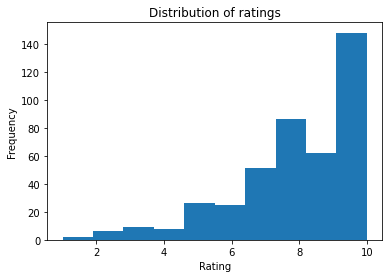

In [122]:
plt.hist(reviews['Rating'])
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of ratings')

In [123]:
#Looking at where guests come from
top10 = reviews.groupby('Country').size().sort_values(0, ascending = False).head(10)
top10

Country
Malaysia          248
Singapore          23
India              21
Australia          16
United Kingdom     10
Sri Lanka           7
Saudi Arabia        7
Bangladesh          6
China               5
Maldives            5
dtype: int64

Text(0.5, 1.0, 'Review tag counts')

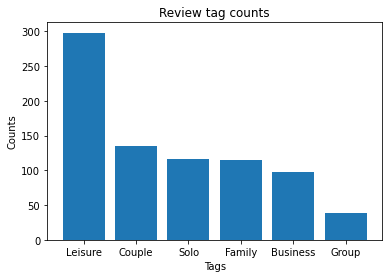

In [127]:
tag_list = ['Business', 'Leisure', 'Solo', 'Couple', 'Group', 'Family']

tag_counts = []
for tag in tag_list:
    n = reviews['Tags'].str.count(tag).sum()
    tag_counts.append(n)

tags = pd.DataFrame({'Tags': tag_list, 'Counts': tag_counts}).sort_values('Counts', ascending = False)

plt.bar(x=tags['Tags'], height=tags['Counts'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.title('Review tag counts')

In [128]:
def wordnet_pos(pos):
    if pos.startswith('J'):
        return wordnet.ADJ
    if pos.startswith('N'):
        return wordnet.NOUN
    if pos.startswith('R'):
        return wordnet.ADV
    if pos.startswith('V'):
        return wordnet.VERB
    else:
        return wordnet.NOUN

def lemmatized_tokens(text):
    text = text.lower()
    pattern = r'\b[a-zA-Z]{3,}\b'
    tokens = nltk.regexp_tokenize(text, pattern)
    tagged_tokens = nltk.pos_tag(tokens)
    
    stop_words = stopwords.words('english')
    new_stopwords = ['good', 'great', 'really', 'hotel', 'need',
                    'even', 'one', 'nice']
    stop_words.extend(new_stopwords)
    stop_words = set(stop_words)
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, wordnet_pos(tag))
                       for (word, tag) in tagged_tokens
                       if word not in stop_words and word not in string.punctuation]
    return lemmatized_words

In [129]:
pos_text = positive_reviews['Positive reviews'].tolist()
positive_corpus = ' '.join(lemmatized_tokens(' '.join(pos_text)))

In [130]:
neg_text = negative_reviews['Negative reviews'].tolist()
negative_corpus = ' '.join(lemmatized_tokens(' '.join(neg_text)))

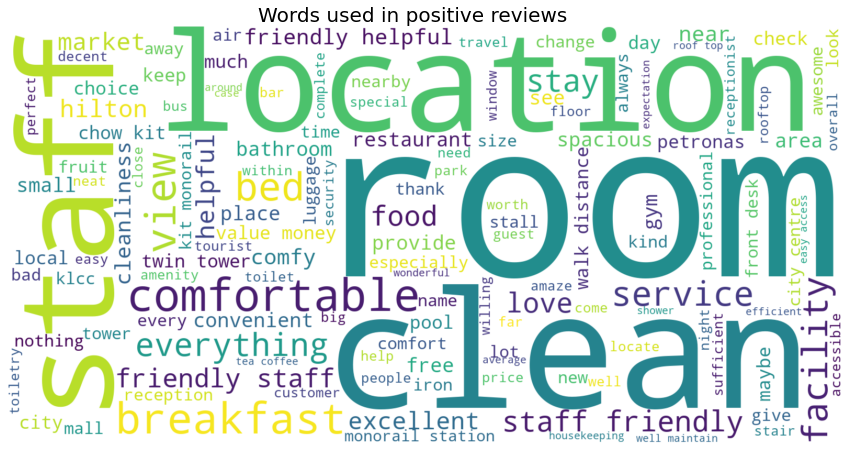

In [131]:
pos_wordcloud = WordCloud(collocations = True, background_color = 'white',
         width = 1600, height = 800, margin = 2, 
          min_font_size = 20).generate(positive_corpus)
plt.figure(figsize = (15,10))
plt.imshow(pos_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.figtext(.5, .8, 'Words used in positive reviews', fontsize = 20, ha = 'center')
plt.show()

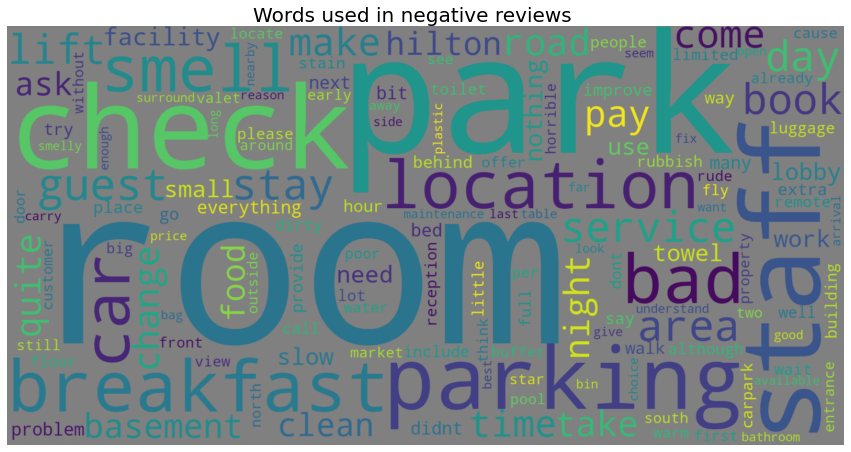

In [191]:
neg_wordcloud = WordCloud(collocations = True, background_color = 'grey',
         width = 1600, height = 800, margin = 2, 
          min_font_size = 20).generate(negative_corpus)
plt.figure(figsize = (15,10))
plt.imshow(neg_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.figtext(.5, .8, 'Words used in negative reviews', fontsize = 20, ha = 'center')
plt.show()

In [133]:
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def polarity(text):
    return TextBlob(text).sentiment.polarity

reviews['Subjectivity'] = reviews['Review'].apply(subjectivity)
reviews['Polarity'] = reviews['Review'].apply(polarity)

def sentiment(polarity):
    if float(polarity) < 0:
        return 'Negative'
    elif float(polarity) == 0:
        return 'Neutral'
    else:
        return 'Positive'
reviews['Sentiment'] = reviews['Polarity'].apply(sentiment)


Text(0.5, 1.0, 'Subjectivity vs Polarity of Reviews of the Hotel')

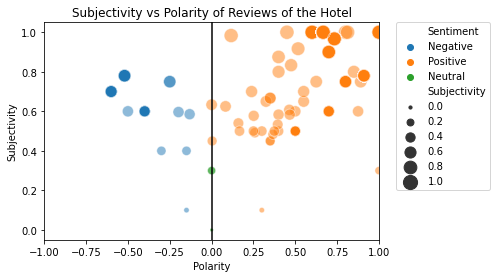

In [140]:
sns.scatterplot(x = 'Polarity', y = 'Subjectivity', data = reviews,
           hue = 'Sentiment', size= 'Subjectivity', sizes=(10, 200),
            alpha = 0.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(-1, 1)
plt.axvline(0, color='k', linestyle='solid')
plt.title('Subjectivity vs Polarity of Reviews of the Hotel')

In [180]:
#LDA for negative reviews
stop_words = ENGLISH_STOP_WORDS.union(['good', 'bad', 'didn', 'like',
                                      'really', 'quite', 'just', 'didnt'])

tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode',
                                ngram_range=(1,2),
                                stop_words = stop_words,
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.9,
                                min_df = 8)
dtm = tfidf_vectorizer.fit_transform(neg_text)
dtm.shape



(207, 28)

In [181]:
print('There are {} negative reviews and {} tokens in the resulting document-term matrix.'
      .format(dtm.shape[0], dtm.shape[1]))

There are 207 negative reviews and 28 tokens in the resulting document-term matrix.


In [182]:
search_grid = {'n_components': [3, 5, 10, 15, 20, 25, 30],
                'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid = search_grid)
model.fit(dtm)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [3, 5, 10, 15, 20, 25, 30]})

In [183]:
best_model = model.best_estimator_
best_model

LatentDirichletAllocation(learning_decay=0.9, n_components=3)

In [184]:
print("The best model has parameters:", model.best_params_)

The best model has parameters: {'learning_decay': 0.9, 'n_components': 3}


In [185]:
print("Log likelihood of the best model is:", model.best_score_)

Log likelihood of the best model is: -231.79324987161698


In [186]:
print("Perplexity of the best model is:", best_model.perplexity(dtm))

Perplexity of the best model is: 44.524643900384476


In [187]:
#Plot log-likelihood vs number of topics
iter_score = model.fit(dtm).cv_results_

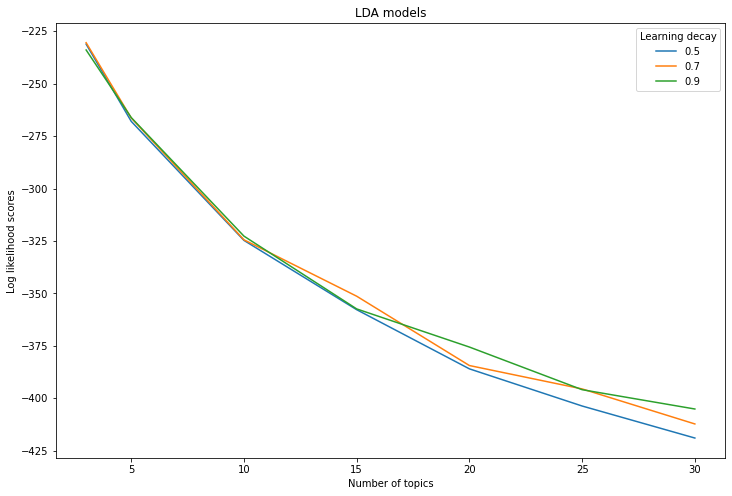

In [188]:
n_topics = [3, 5, 10, 15, 20, 25, 30]
decay_5 = [iter_score['mean_test_score'][iter_score['params'].index(v)] for v in iter_score['params'] if v['learning_decay'] == 0.5]
decay_7 = [iter_score['mean_test_score'][iter_score['params'].index(v)] for v in iter_score['params'] if v['learning_decay'] == 0.7]
decay_9 = [iter_score['mean_test_score'][iter_score['params'].index(v)] for v in iter_score['params'] if v['learning_decay'] == 0.9]

plt.figure(figsize=(12,8))
plt.plot(n_topics, decay_5, label = '0.5')
plt.plot(n_topics, decay_7, label = '0.7')
plt.plot(n_topics, decay_9, label = '0.9')
plt.title('LDA models')
plt.xlabel('Number of topics')
plt.ylabel('Log likelihood scores')
plt.legend(title = 'Learning decay', loc = 'best')
plt.show()

In [189]:
best_model.components_

topic_dict = {}
topic_words = tfidf_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(best_model.components_):
    topic_dict['Topic %d words' %(topic_idx+1)] = ['{}'.format(topic_words[i])
                                                    for i in topic.argsort()[:-21:-1]]
    topic_dict['Topic %d weights' %(topic_idx+1)] = ['{}'.format(topic[i]) 
                                                     for i in topic.argsort()[:-21:-1]]


pd.DataFrame(topic_dict)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,parking,29.10905970665818,location,13.479491548009642,room,20.925452119872098
1,hotel,13.259928120232791,staff,8.631809570981561,breakfast,14.628823693536049
2,check,8.619026622621051,service,7.297545011541115,car,6.85946398069632
3,need,8.03019624360528,night,6.719238702308259,lift,5.846668165816081
4,smell,6.574359517812087,time,6.666740794235332,park,5.802181231393135
5,road,5.63088992195704,pool,6.0846778942246615,stay,5.649557067378203
6,day,5.301641510866574,bit,5.502099484107594,slow,4.664523326937327
7,basement,5.214686662807486,building,4.993033982758855,clean,4.504939052691485
8,area,4.582169789433162,lobby,4.947623412290245,hotel,0.5278056590507639
9,staff,3.4302347415555,area,4.841836092440016,smell,0.4107429048263589


This should give the hotel's management some insights on what their guests were mostly unsatisfied about: parking, staff, breakfast and room condition/cleanliness. The management should still look at the detail reviews to see exactly what improvements are needed.